In [4]:
import os
from glob import glob
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from multiprocessing import Pool
%matplotlib inline

base_dir='/groups/ahrens/ahrenslab/FROM_TIER2/Yu/SPIM/active_datasets/20170131/fish5/20170131_5_2_GFAPRGECO_DBHGC5slow_5dpf_waist_CLPause_0GAIN_GAINMODULATION_20170131_234518/'
ep_fname = '/groups/ahrens/ahrenslab/davis/tmp/20170131/20170131_5_2_GFAPGC_HUCRGECO_5dpf_waist_singleplane_CLPAUSE_0GAIN_GAINMODULATION.10chFlt'
source_files = glob(base_dir + 'TM*.stack')
source_files.sort()

def stack_loader(fname, n_dim=3):
    from os.path import split, sep
    from fish.image.vol import get_stack_dims
    from numpy import fromfile
    
    dims = get_stack_dims(split(fname)[0] + sep)
    if n_dim == 2:
        dims = dims[:2]
    return fromfile(fname, dtype='uint16').reshape(dims[::-1])
    
def get_crossings(v, th):
    return (v[:-1] < th) * (v[1:] > th)

def draw_slices(axis, roi, color='m'):
    axis.add_patch(
    patches.Rectangle(
        (roi[1].start, roi[0].start),  
        roi[1].stop - roi[1].start,    
        roi[0].stop - roi[0].start, fill=False, color=color, linewidth=3))

In [5]:
from fish.ephys.ephys import load
ep_dat = load(ep_fname)
cam = np.where(get_crossings(ep_dat[2], 3))[0]

cam = cam[0:len(source_files)]

[None, None, None, None]

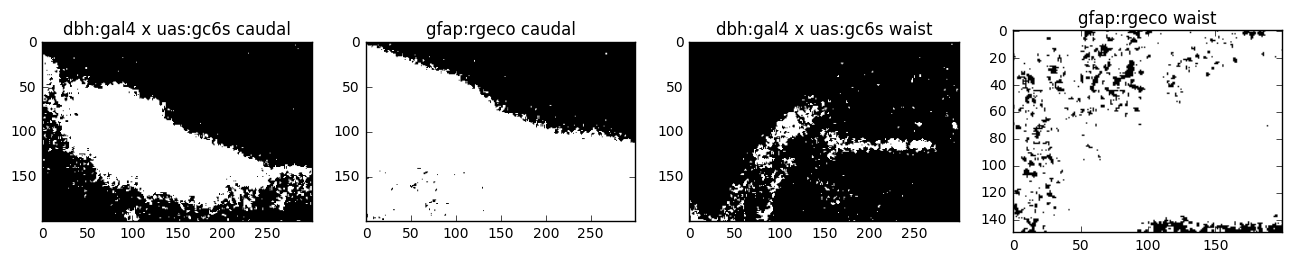

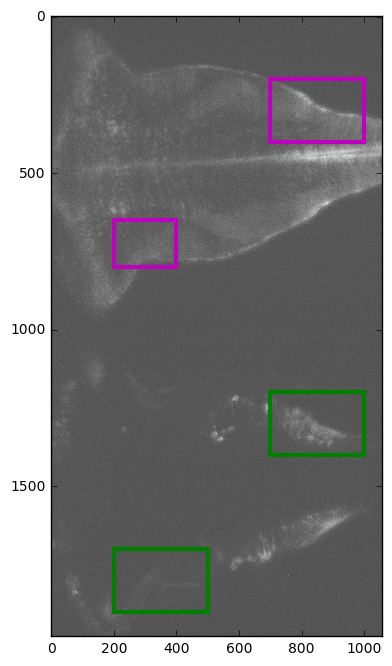

In [7]:
from scipy.ndimage.filters import median_filter
sample = stack_loader(source_files[100], n_dim=2)

rois = [(slice(1200, 1400), slice(700, 1000)), 
        (slice(200, 400), slice(700, 1000)),
       (slice(1700,1900), slice(200,500)),
       (slice(650,800), slice(200,400))]
colors = ['g', 'm', 'g', 'm']
labels = ['dbh:gal4 x uas:gc6s caudal', 'gfap:rgeco caudal', 'dbh:gal4 x uas:gc6s waist', 'gfap:rgeco waist']
ths = [105, 105, 105, 105]
masks = [median_filter(sample[r] > ths[ind], size=3) for ind, r in enumerate(rois)]

fig, axs = plt.subplots(ncols=len(rois), figsize=(16,16))
for ind, ax in enumerate(axs):
    ax.imshow(masks[ind], cmap='gray')
    ax.set_title(labels[ind])

fig, ax = plt.subplots(ncols=1, figsize=(8,8))
ax.imshow(sample ** .5, cmap='gray')
[draw_slices(ax, r, colors[ind]) for ind, r in enumerate(rois)]



In [9]:
%%time
plr_t = range(0, 1000)
roi_ts = np.zeros([len(rois), len(plr_t)])
for ind, t in enumerate(plr_t):
    fn = source_files[t]
    dat = stack_loader(fn, n_dim=2)
    for r in range(len(rois)):
        roi_ts[r,ind] = (dat[rois[r]] * masks[r]).mean();

CPU times: user 1.43 s, sys: 2.46 s, total: 3.89 s
Wall time: 28.8 s
